# PyBERT Viterbi Decoder Testing

Original author: David Banas <capn.freako@gmail.com>  
Original date: June 21, 2025

Copyright &copy; 2025 David Banas; all rights reserved World wide.

## Introduction

Recently, a [Viterbi decoder](https://en.wikipedia.org/wiki/Viterbi_decoder) was added to the _PyBERT_ Rx model, as an alternative to the already existing DFE.
This [Jupyter](https://jupyter.org/) notebook was constructed to exercise the new Viterbi decoder in PyBERT.
Specifically, it is used to compare the performance of that Viterbi decoder to that of the DFE.

## Imports & Helper Functions

In this section we import any required external Python modules and define any needed local helper functions.

In [24]:
%matplotlib inline

from typing import TypeAlias

import numpy        as np
import numpy.typing as npt

from matplotlib    import pyplot as plt
from pybert.pybert import PyBERT

Rvec: TypeAlias = npt.NDArray[np.float64]

# Instantiate and congiure the DUT.
thePyBERT = PyBERT(run_simulation=True, gui=False)
print(thePyBERT.status)
print(thePyBERT.console_log)
cur_log_line = len(thePyBERT.console_log.split("\n"))

def safe_log10(x: Rvec) -> Rvec:
    """
    Take log10 of input argument, guarding against division by zero.
    """
    y = np.where(x == 0, 1e-20 * np.ones(len(x)), x)
    return np.log10(y)


Ready.
PyBERT Console Log

[2025-06-21 15:55:57.386969]: PyBERT: Started.
[2025-06-21 15:55:57.386969]: PyBERT: System: Windows 10
[2025-06-21 15:55:57.386969]: PyBERT: Python Version: 3.10.11
[2025-06-21 15:55:57.386969]: PyBERT: PyBERT Version: 7.2.1
[2025-06-21 15:55:57.386969]: PyBERT: PyAMI Version: 7.2.2
[2025-06-21 15:55:57.386969]: PyBERT: GUI Toolkit: qt
[2025-06-21 15:55:57.386969]: PyBERT: Kiva Backend: image



## Performance vs. Channel Loss

In this section we evaluate the performance comparison between Viterbi and DFE as a function of channel loss.

The Tx deemphasis and Rx CTLE peaking have been previously optimized for each channel length used here.
And those optimum equalization settings have been saved to certain PyBERT configuration files, which are used in the code below.

**Note:** The optimizations were performed under the assumption of `N_TAPS` DFE taps available.
(i.e. - The optimization was done in such a way as to favor the DFE in the following comparisons.)


In [29]:
N_TAPS = 4

bit_errs_dfe     = []
bit_errs_viterbi = []
chnl_losses      = []
for cfg_file in ["chnl_1p5.yaml", "chnl_1p75.yaml", "chnl_2p0.yaml", "chnl_2p25.yaml"]:
    thePyBERT.load_configuration(cfg_file)
    thePyBERT.rx_use_viterbi     = True
    thePyBERT.rx_viterbi_symbols = N_TAPS
    thePyBERT.use_agc = False
    thePyBERT.debug   = False
    thePyBERT.rn = 0.001
    thePyBERT.pn = 0.000
    thePyBERT.nbits    = 20_000
    thePyBERT.eye_bits = 10_000
    thePyBERT.simulate(initial_run=False)
    bit_errs_dfe.append(thePyBERT.bit_errs)
    bit_errs_viterbi.append(thePyBERT.bit_errs_viterbi)
    chnl_losses.append(np.abs(thePyBERT.chnl_H[np.where(thePyBERT.f >= (thePyBERT.bit_rate * 1e9 / 2))[0][0]]))

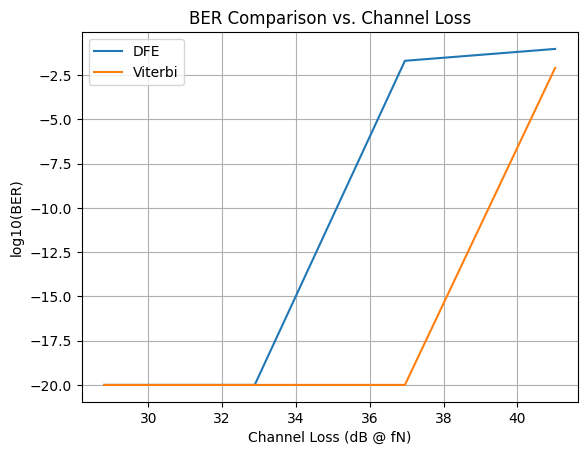

In [30]:
plt.plot(-20 * np.log10(np.array(chnl_losses)),
         safe_log10(np.array(bit_errs_dfe) / 10_000), label="DFE")
plt.plot(-20 * np.log10(np.array(chnl_losses)),
         safe_log10(np.array(bit_errs_viterbi) / 10_000), label="Viterbi")
plt.title("BER Comparison vs. Channel Loss")
plt.xlabel("Channel Loss (dB @ fN)")
plt.ylabel("log10(BER)")
plt.grid()
plt.legend()
plt.show()


## Performance vs. Noise

In this section we evaluate the performance comparison between Viterbi and DFE as a function of channel noise.

We'll use the 1.75m (33 dB) channel length, as it's the longest yielding 0 BER in both cases above.

In [32]:
bit_errs_dfe_noise     = []
bit_errs_viterbi_noise = []
noise_sigmas     = [0.001, 0.01, 0.1, 1.0]
thePyBERT.load_configuration("chnl_1p75.yaml")
thePyBERT.rx_use_viterbi     = True
thePyBERT.rx_viterbi_symbols = N_TAPS
thePyBERT.use_agc  = False
thePyBERT.debug    = False
thePyBERT.pn       = 0.000
thePyBERT.nbits    = 20_000
thePyBERT.eye_bits = 10_000
for noise_sigma in noise_sigmas:
    thePyBERT.rn = noise_sigma
    thePyBERT.simulate(initial_run=False)
    bit_errs_dfe_noise.append(thePyBERT.bit_errs)
    bit_errs_viterbi_noise.append(thePyBERT.bit_errs_viterbi)


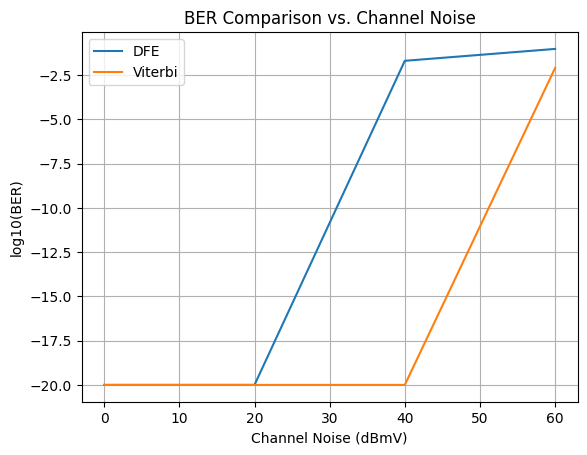

In [33]:
plt.plot(20 * safe_log10(np.array(noise_sigmas) / 1e-3),
         safe_log10(np.array(bit_errs_dfe) / 10_000), label="DFE")
plt.plot(20 * safe_log10(np.array(noise_sigmas) / 1e-3),
         safe_log10(np.array(bit_errs_viterbi) / 10_000), label="Viterbi")
plt.title("BER Comparison vs. Channel Noise")
plt.xlabel("Channel Noise (dBmV)")
plt.ylabel("log10(BER)")
plt.grid()
plt.legend()
plt.show()
